In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
import sys
sys.path.append('../src')

from data.data_loader import MovielensDataloader
from data.preprocessor import DataPreprocessor
from models.collaborative_filtering import CollaborativeFiltering, MemoryEfficientCF
from models.matrix_factorization import SVDRecommender, NMFRecommender, ALSRecommender, BiasedMF
from models.content_based import ContentBasedRecommender, TFIDFContentRecommender
from models.deep_learning import NeuralCollaborativeFiltering, AutoEncoder, WideAndDeep
from models.hybrid import WeightedHybrid, SwitchingHybrid, MixedHybrid, FeatureCombinationHybrid
from evaluation.metrics import RecommendationMetrics
from evaluation.evaluator import RecommendationEvaluator

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("=== Movie Recommendation System - MovieLens 100k ===")
print("Implementing various ML models for recommendation engines\n")

=== Movie Recommendation System - MovieLens 100k ===
Implementing various ML models for recommendation engines



In [2]:
print("1. Loading and Exploring Data")
print("-" * 50)

# Initialize data loader
loader = MovielensDataloader('../data/raw/ml-100k/')

# Load all datasets
ratings, movies, users = loader.load_all_data()

print(f"Dataset Statistics:")
print(f"- Users: {ratings['user_id'].nunique()}")
print(f"- Items: {ratings['item_id'].nunique()}")
print(f"- Ratings: {len(ratings)}")
print(f"- Density: {len(ratings) / (ratings['user_id'].nunique() * ratings['item_id'].nunique()) * 100:.2f}%")
print(f"- Rating range: {ratings['rating'].min()} - {ratings['rating'].max()}")
print()

1. Loading and Exploring Data
--------------------------------------------------
Dataset Statistics:
- Users: 943
- Items: 1682
- Ratings: 100000
- Density: 6.30%
- Rating range: 1 - 5



In [3]:
# Basic statistics
print("Rating Distribution:")
print(ratings['rating'].value_counts().sort_index())
print()

print("User Demographics:")
print(f"Age range: {users['age'].min()} - {users['age'].max()}")
print(f"Gender distribution: {users['gender'].value_counts()}")
print()


Rating Distribution:
rating
1     6110
2    11370
3    27145
4    34174
5    21201
Name: count, dtype: int64

User Demographics:
Age range: 7 - 73
Gender distribution: gender
M    670
F    273
Name: count, dtype: int64



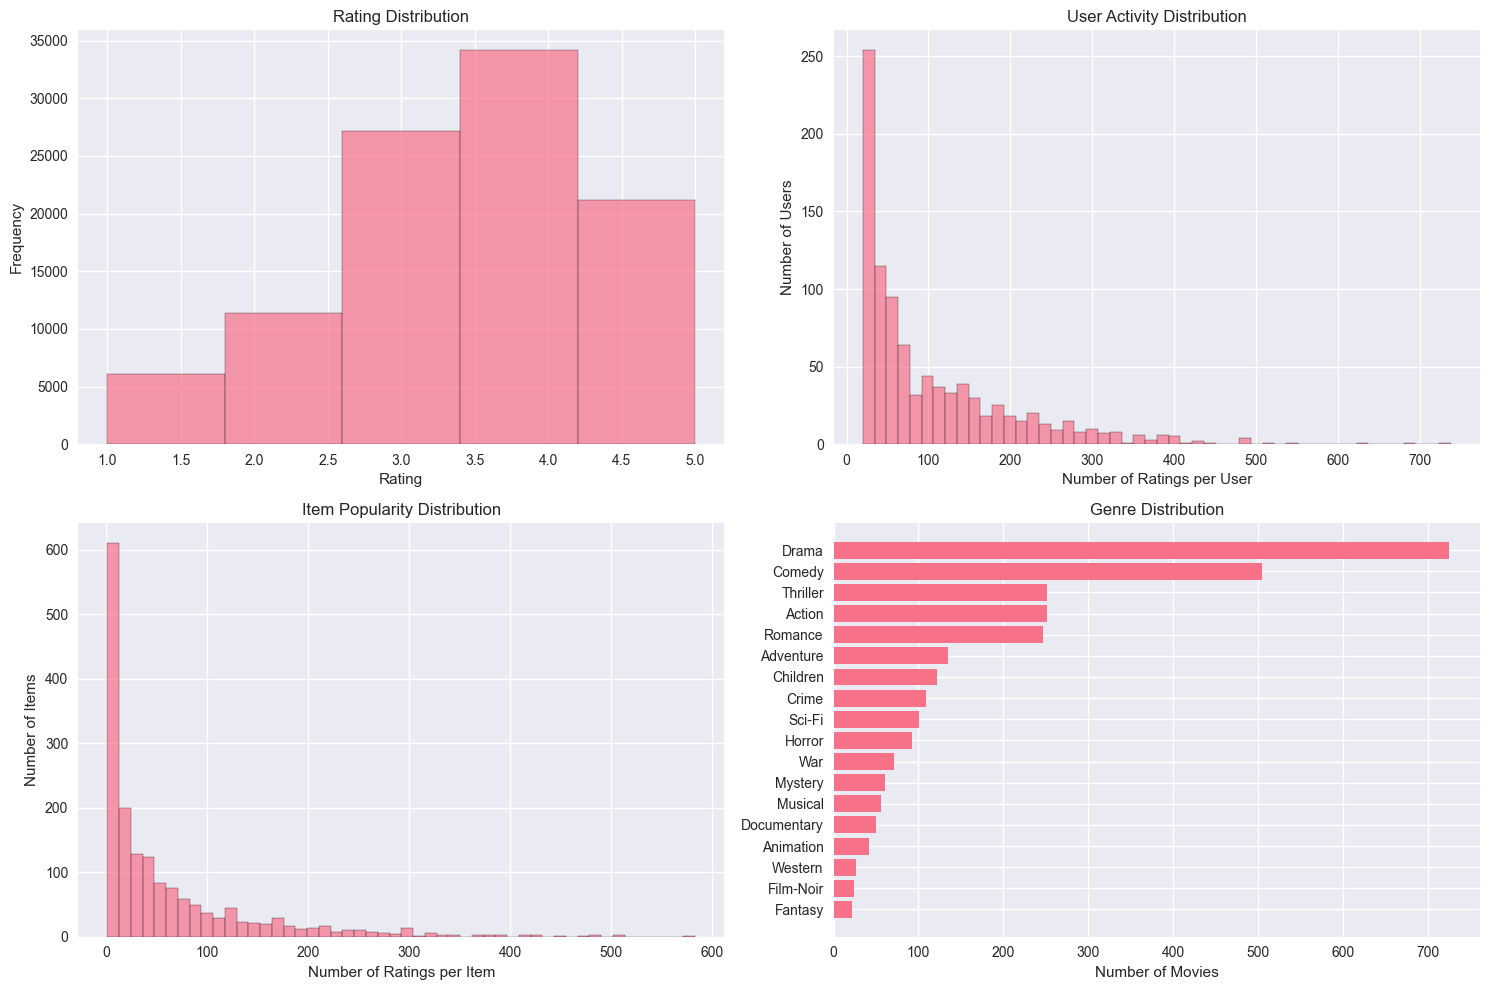

In [4]:
# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Rating distribution
axes[0, 0].hist(ratings['rating'], bins=5, alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Rating Distribution')
axes[0, 0].set_xlabel('Rating')
axes[0, 0].set_ylabel('Frequency')

# User activity distribution
user_activity = ratings.groupby('user_id').size()
axes[0, 1].hist(user_activity, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('User Activity Distribution')
axes[0, 1].set_xlabel('Number of Ratings per User')
axes[0, 1].set_ylabel('Number of Users')

# Item popularity distribution
item_popularity = ratings.groupby('item_id').size()
axes[1, 0].hist(item_popularity, bins=50, alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Item Popularity Distribution')
axes[1, 0].set_xlabel('Number of Ratings per Item')
axes[1, 0].set_ylabel('Number of Items')

# Genre distribution
genre_cols = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime',
             'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
             'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
genre_counts = movies[genre_cols].sum().sort_values(ascending=True)
axes[1, 1].barh(range(len(genre_counts)), genre_counts.values)
axes[1, 1].set_yticks(range(len(genre_counts)))
axes[1, 1].set_yticklabels(genre_counts.index)
axes[1, 1].set_title('Genre Distribution')
axes[1, 1].set_xlabel('Number of Movies')

plt.tight_layout()
plt.savefig('results/data_exploration.png', dpi=300, bbox_inches='tight')
plt.show()

# Preprocessing

In [5]:
# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================

print("2. Data Preprocessing")
print("-" * 50)

# Initialize preprocessor
preprocessor = DataPreprocessor()

# Create user-item matrix
user_item_matrix, matrix_info = preprocessor.create_user_item_matrix(ratings)

print(f"User-Item Matrix Shape: {user_item_matrix.shape}")
print(f"Matrix Sparsity: {matrix_info['sparsity']:.4f}")
print(f"Total Ratings: {matrix_info['n_ratings']}")
print()

# Train-test split using predefined split
train_data, test_data = loader.get_train_test_split()

# Convert to indexed format
train_ratings = train_data.copy()
test_ratings = test_data.copy()

train_ratings['user_idx'] = preprocessor.user_encoder.transform(train_ratings['user_id'])
train_ratings['item_idx'] = preprocessor.item_encoder.transform(train_ratings['item_id'])
test_ratings['user_idx'] = preprocessor.user_encoder.transform(test_ratings['user_id'])
test_ratings['item_idx'] = preprocessor.item_encoder.transform(test_ratings['item_id'])

# Create training matrix
train_matrix = np.zeros_like(user_item_matrix)
for _, row in train_ratings.iterrows():
    train_matrix[int(row['user_idx']), int(row['item_idx'])] = row['rating']

print(f"Training set: {len(train_ratings)} ratings")
print(f"Test set: {len(test_ratings)} ratings")
print(f"Training matrix sparsity: {1 - np.sum(train_matrix > 0) / train_matrix.size:.4f}")
print()


2. Data Preprocessing
--------------------------------------------------
User-Item Matrix Shape: (943, 1682)
Matrix Sparsity: 0.9370
Total Ratings: 100000

Training set: 90570 ratings
Test set: 9430 ratings
Training matrix sparsity: 0.9429



# Model Implementation

In [6]:
# ============================================================================
# 3. MODEL IMPLEMENTATIONS
# ============================================================================

print("3. Training Recommendation Models")
print("-" * 50)

# Dictionary to store all trained models
trained_models = {}

3. Training Recommendation Models
--------------------------------------------------


In [7]:
# ============================================================================
# 3.1 COLLABORATIVE FILTERING
# ============================================================================

print("3.1 Collaborative Filtering Models")
print("-" * 30)

# User-based CF with Cosine similarity
print("Training User-Based Collaborative Filtering (Cosine)...")
user_cf_cosine = CollaborativeFiltering(similarity_metric='cosine', n_neighbors=50)
user_cf_cosine.fit(train_matrix)
trained_models['UserCF_Cosine'] = user_cf_cosine

# User-based CF with Pearson correlation
print("Training User-Based Collaborative Filtering (Pearson)...")
user_cf_pearson = CollaborativeFiltering(similarity_metric='pearson', n_neighbors=50)
user_cf_pearson.fit(train_matrix)
trained_models['UserCF_Pearson'] = user_cf_pearson

print("Collaborative Filtering models trained successfully!\n")

3.1 Collaborative Filtering Models
------------------------------
Training User-Based Collaborative Filtering (Cosine)...
Training User-Based Collaborative Filtering (Pearson)...
Collaborative Filtering models trained successfully!



In [8]:
# ============================================================================
# 3.2 MATRIX FACTORIZATION
# ============================================================================

print("3.2 Matrix Factorization Models")
print("-" * 30)

# SVD
print("Training SVD...")
svd_model = SVDRecommender(n_factors=100, random_state=42)
svd_model.fit(train_matrix)
trained_models['SVD'] = svd_model

# NMF
print("Training NMF...")
nmf_model = NMFRecommender(n_factors=50, random_state=42)
nmf_model.fit(train_matrix)
trained_models['NMF'] = nmf_model

# ALS
print("Training ALS...")
als_model = ALSRecommender(n_factors=50, reg_param=0.1, max_iter=10, random_state=42)
als_model.fit(train_matrix)
trained_models['ALS'] = als_model

# Biased MF
print("Training Biased Matrix Factorization...")
biased_mf = BiasedMF(n_factors=50, learning_rate=0.01, reg_param=0.01, n_epochs=50, random_state=42)
biased_mf.fit(train_ratings[['user_idx', 'item_idx', 'rating']])
trained_models['BiasedMF'] = biased_mf

print("Matrix Factorization models trained successfully!\n")

3.2 Matrix Factorization Models
------------------------------
Training SVD...
Training NMF...
Training ALS...
Iteration 0, MSE: 0.9614
Iteration 5, MSE: 0.0906
Training Biased Matrix Factorization...
Epoch 0, RMSE: 1.0145
Epoch 10, RMSE: 0.7469
Epoch 20, RMSE: 0.5411
Epoch 30, RMSE: 0.4462
Epoch 40, RMSE: 0.3971
Matrix Factorization models trained successfully!



In [9]:
# ============================================================================
# 3.3 CONTENT-BASED FILTERING
# ============================================================================

print("3.3 Content-Based Models")
print("-" * 30)

# Standard Content-Based
print("Training Content-Based Recommender...")
content_model = ContentBasedRecommender(similarity_metric='cosine')
content_model.fit(movies, train_ratings)
trained_models['ContentBased'] = content_model

# TF-IDF Content-Based
print("Training TF-IDF Content-Based Recommender...")
tfidf_model = TFIDFContentRecommender(max_features=1000)
tfidf_model.fit(movies, train_ratings)
trained_models['TFIDF_Content'] = tfidf_model

print("Content-Based models trained successfully!\n")


3.3 Content-Based Models
------------------------------
Training Content-Based Recommender...
Created feature matrix with shape: (1682, 20)
Training TF-IDF Content-Based Recommender...
TF-IDF matrix shape: (1682, 1000)
Vocabulary size: 1000
Content-Based models trained successfully!



In [10]:
# ============================================================================
# 3.4 DEEP LEARNING MODELS
# ============================================================================

print("3.4 Deep Learning Models")
print("-" * 30)

# Neural Collaborative Filtering
print("Training Neural Collaborative Filtering...")
ncf_model = NeuralCollaborativeFiltering(
    n_users=matrix_info['n_users'],
    n_items=matrix_info['n_items'],
    embedding_dim=50,
    hidden_units=[128, 64, 32],
    dropout_rate=0.2
)
ncf_model.build_model()

# Train NCF
val_split_idx = int(len(train_ratings) * 0.8)
ncf_train = train_ratings.iloc[:val_split_idx]
ncf_val = train_ratings.iloc[val_split_idx:]

ncf_model.fit(ncf_train, ncf_val, epochs=50, batch_size=256, verbose=0)
trained_models['NCF'] = ncf_model

# AutoEncoder
print("Training AutoEncoder...")
autoencoder = AutoEncoder(
    input_dim=matrix_info['n_items'],
    encoding_dims=[512, 256, 128],
    dropout_rate=0.2
)
autoencoder.build_model()
autoencoder.fit(train_matrix, epochs=50, batch_size=32, verbose=0)
trained_models['AutoEncoder'] = autoencoder

print("Deep Learning models trained successfully!\n")

3.4 Deep Learning Models
------------------------------
Training Neural Collaborative Filtering...
Training AutoEncoder...
Deep Learning models trained successfully!



In [11]:
# ============================================================================
# 3.5 HYBRID MODELS
# ============================================================================

print("3.5 Hybrid Models")
print("-" * 30)

# Weighted Hybrid
print("Training Weighted Hybrid...")
base_models_for_hybrid = {
    'UserCF': user_cf_cosine,
    'SVD': svd_model,
    'ContentBased': content_model
}

weighted_hybrid = WeightedHybrid(
    models=base_models_for_hybrid,
    weights={'UserCF': 0.4, 'SVD': 0.4, 'ContentBased': 0.2}
)
weighted_hybrid.fit()
trained_models['WeightedHybrid'] = weighted_hybrid

# Switching Hybrid
print("Training Switching Hybrid...")
switching_hybrid = SwitchingHybrid(
    models=base_models_for_hybrid,
    switching_criteria='user_profile_size'
)
switching_hybrid.fit(train_matrix, train_ratings)
trained_models['SwitchingHybrid'] = switching_hybrid

print("Hybrid models trained successfully!\n")

3.5 Hybrid Models
------------------------------
Training Weighted Hybrid...
Weighted Hybrid: Component models should be fitted individually
Training Switching Hybrid...
Switching Hybrid fitted with 3 models
Hybrid models trained successfully!



# Model Evaluation

In [12]:
print("4. Model Evaluation")
print("-" * 50)

# Initialize evaluator
evaluator = RecommendationEvaluator(k_values=[5, 10, 20], threshold=3.5)

# Evaluate all models
evaluation_results = []

for model_name, model in trained_models.items():
    print(f"Evaluating {model_name}...")
    
    try:
        # Predict test ratings for accuracy metrics
        y_true = []
        y_pred = []
        
        for _, row in test_ratings.iterrows():
            user_idx = int(row['user_idx'])
            item_idx = int(row['item_idx'])
            true_rating = row['rating']
            
            try:
                if model_name == 'AutoEncoder':
                    pred_rating = model.predict(user_idx, item_idx, train_matrix)
                else:
                    pred_rating = model.predict(user_idx, item_idx)
                
                y_true.append(true_rating)
                y_pred.append(pred_rating)
            except:
                continue
        
        if len(y_true) > 0:
            # Accuracy metrics
            accuracy_results = evaluator.evaluate_accuracy(np.array(y_true), np.array(y_pred))
            
            # Ranking metrics (sample of users for efficiency)
            test_users = test_ratings['user_idx'].unique()[:100]  # Sample 100 users
            test_sample = test_ratings[test_ratings['user_idx'].isin(test_users)]
            
            # Fix: call recommend_items correctly for CollaborativeFiltering
            if isinstance(model, CollaborativeFiltering):
                ranking_results = evaluator.evaluate_ranking(test_sample, model, None)
            else:
                ranking_results = evaluator.evaluate_ranking(test_sample, model, train_matrix)
            
            # Combine results
            result = {'Model': model_name}
            result.update(accuracy_results)
            result.update(ranking_results)
            evaluation_results.append(result)
        
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")
        continue

# Convert to DataFrame for better visualization
results_df = pd.DataFrame(evaluation_results)
print("\n=== Model Comparison Results ===")
print(results_df.round(4))

# Save results
results_df.to_csv('results/model_comparison.csv', index=False)

4. Model Evaluation
--------------------------------------------------
Evaluating UserCF_Cosine...
Evaluating UserCF_Pearson...
Evaluating SVD...
Evaluating NMF...
Evaluating ALS...
Evaluating BiasedMF...
Evaluating ContentBased...
Evaluating TFIDF_Content...
Evaluating NCF...
Evaluating AutoEncoder...
Evaluating WeightedHybrid...
Evaluating SwitchingHybrid...

=== Model Comparison Results ===
              Model    RMSE     MAE  Correlation  precision_at_5  \
0     UserCF_Cosine  0.9654  0.7536       0.5204           0.012   
1    UserCF_Pearson  0.9581  0.7476       0.5297           0.008   
2               SVD  1.1851  0.9060       0.4411           0.102   
3               NMF  2.2054  1.9287       0.2369           0.218   
4               ALS  1.4966  1.1734       0.2766           0.018   
5          BiasedMF  1.0535  0.8193       0.4482           0.048   
6      ContentBased  1.2359  0.9704       0.0816           0.016   
7     TFIDF_Content  1.1486  0.9545       0.0645           

# Visualization


5. Results Visualization
--------------------------------------------------


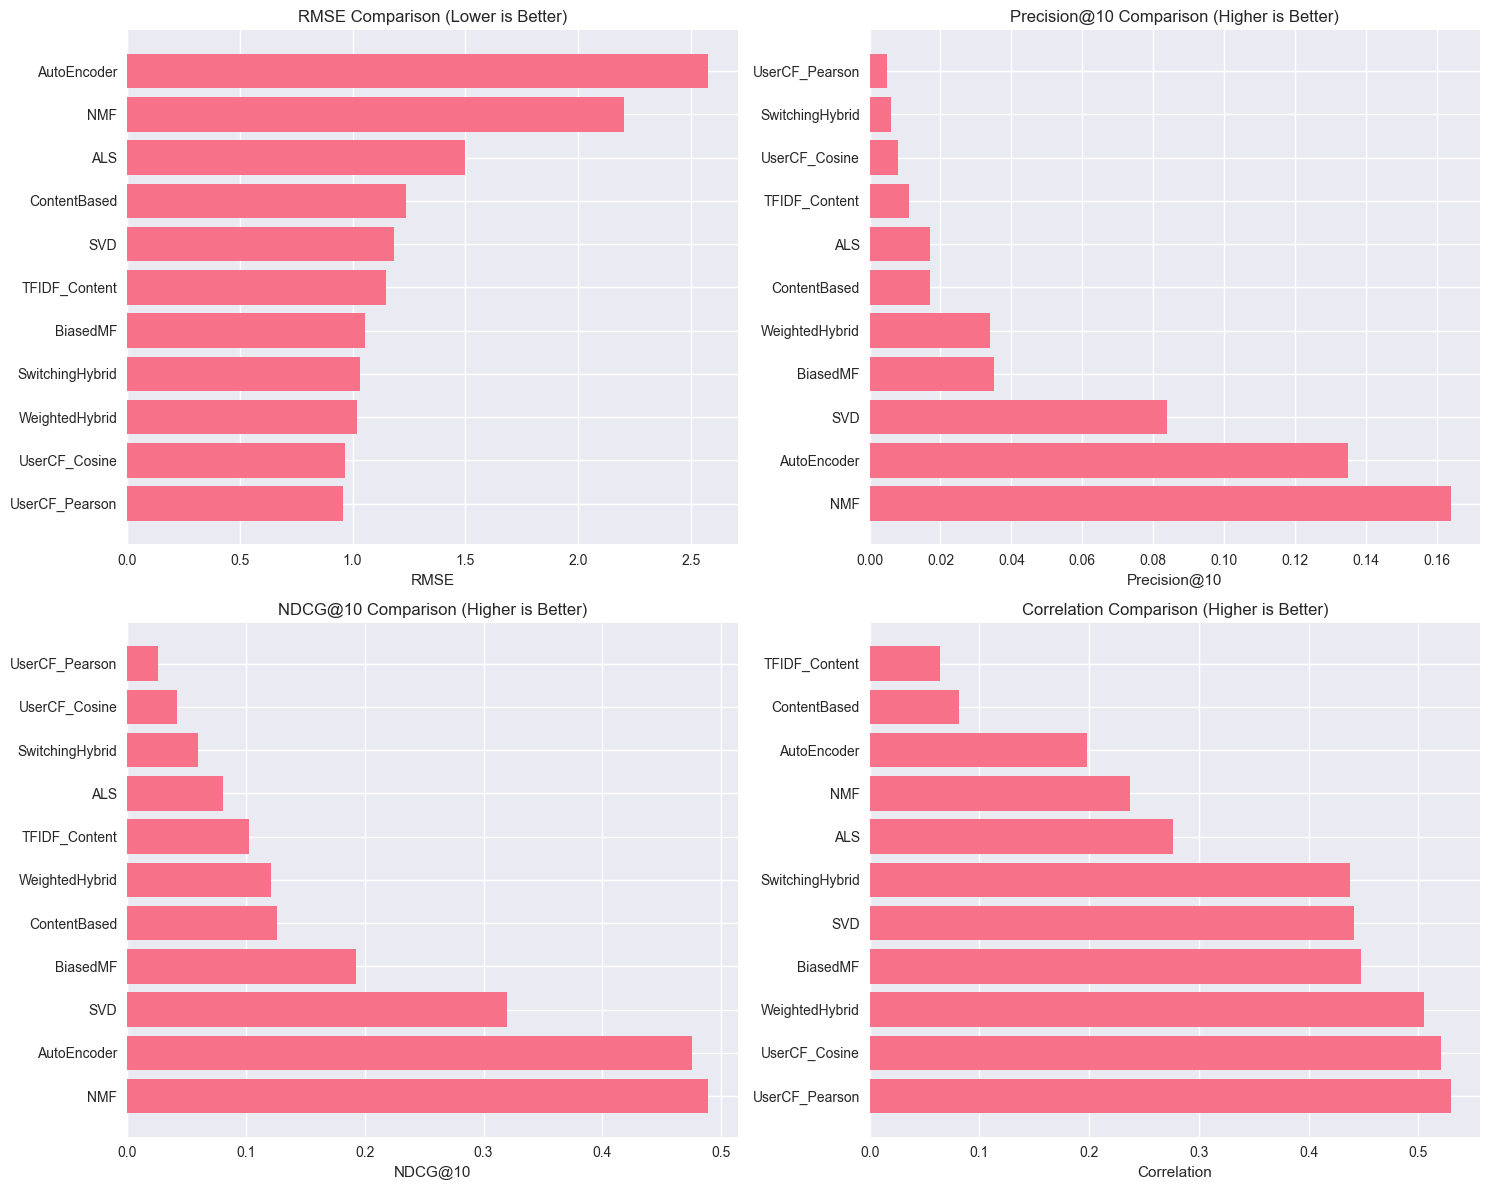

In [13]:
# ============================================================================
# 5. VISUALIZATION AND ANALYSIS
# ============================================================================

print("\n5. Results Visualization")
print("-" * 50)

# Plot comparison results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# RMSE Comparison
if 'RMSE' in results_df.columns:
    results_df_sorted = results_df.sort_values('RMSE')
    axes[0, 0].barh(results_df_sorted['Model'], results_df_sorted['RMSE'])
    axes[0, 0].set_title('RMSE Comparison (Lower is Better)')
    axes[0, 0].set_xlabel('RMSE')

# Precision@10 Comparison
if 'precision_at_10' in results_df.columns:
    results_df_sorted = results_df.sort_values('precision_at_10', ascending=False)
    axes[0, 1].barh(results_df_sorted['Model'], results_df_sorted['precision_at_10'])
    axes[0, 1].set_title('Precision@10 Comparison (Higher is Better)')
    axes[0, 1].set_xlabel('Precision@10')

# NDCG@10 Comparison
if 'ndcg_at_10' in results_df.columns:
    results_df_sorted = results_df.sort_values('ndcg_at_10', ascending=False)
    axes[1, 0].barh(results_df_sorted['Model'], results_df_sorted['ndcg_at_10'])
    axes[1, 0].set_title('NDCG@10 Comparison (Higher is Better)')
    axes[1, 0].set_xlabel('NDCG@10')

# Correlation Comparison
if 'Correlation' in results_df.columns:
    results_df_sorted = results_df.sort_values('Correlation', ascending=False)
    axes[1, 1].barh(results_df_sorted['Model'], results_df_sorted['Correlation'])
    axes[1, 1].set_title('Correlation Comparison (Higher is Better)')
    axes[1, 1].set_xlabel('Correlation')

plt.tight_layout()
plt.savefig('results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# Recommendation examples

In [14]:
# ============================================================================
# 6. RECOMMENDATION EXAMPLES
# ============================================================================

print("\n6. Recommendation Examples")
print("-" * 50)

# Select a test user for recommendations
test_user_id = 100  # Original user ID
test_user_idx = preprocessor.user_encoder.transform([test_user_id])[0]

print(f"Generating recommendations for User {test_user_id} (index {test_user_idx})")
print()

# Show user's rating history
user_ratings_history = ratings[ratings['user_id'] == test_user_id].merge(
    movies[['item_id', 'title']], on='item_id'
).sort_values('rating', ascending=False)

print("User's Rating History (Top 10):")
print(user_ratings_history[['title', 'rating']].head(10))
print()

# Generate recommendations from different models
recommendation_examples = {}

for model_name in ['SVD', 'UserCF_Cosine', 'ContentBased', 'WeightedHybrid']:
    if model_name in trained_models:
        try:
            recs = trained_models[model_name].recommend_items(test_user_idx, train_matrix, n_recommendations=5)
            
            # Convert item indices back to titles
            rec_titles = []
            for item_idx, pred_rating in recs:
                original_item_id = preprocessor.item_encoder.classes_[item_idx]
                movie_title = movies[movies['item_id'] == original_item_id]['title'].iloc[0]
                rec_titles.append((movie_title, pred_rating))
            
            recommendation_examples[model_name] = rec_titles
            
        except Exception as e:
            print(f"Error generating recommendations for {model_name}: {e}")

# Display recommendations
for model_name, recs in recommendation_examples.items():
    print(f"\n{model_name} Recommendations:")
    for i, (title, score) in enumerate(recs, 1):
        print(f"{i}. {title} (Score: {score:.2f})")


6. Recommendation Examples
--------------------------------------------------
Generating recommendations for User 100 (index 99)

User's Rating History (Top 10):
                              title  rating
14        As Good As It Gets (1997)       5
22                   Titanic (1997)       5
58                 Apt Pupil (1998)       5
8          L.A. Confidential (1997)       4
19  Replacement Killers, The (1998)       4
25           Peacemaker, The (1997)       4
26             Air Force One (1997)       4
13                 Dark City (1998)       4
4                     Sphere (1998)       4
5                    Amistad (1997)       4

Error generating recommendations for UserCF_Cosine: CollaborativeFiltering.recommend_items() got multiple values for argument 'n_recommendations'

SVD Recommendations:
1. L.A. Confidential (1997) (Score: 5.00)
2. Amistad (1997) (Score: 5.00)
3. Great Day in Harlem, A (1994) (Score: 4.67)
4. Little City (1998) (Score: 4.64)
5. Star Kid (1997) (Score: 

# Advanced Analysis

In [15]:
print("\n\n7. Advanced Analysis")
print("-" * 50)

# Model performance across different user groups
print("7.1 Performance by User Activity Level")
print("-" * 40)

# Categorize users by activity level
user_activity = train_ratings.groupby('user_idx').size()
activity_quantiles = user_activity.quantile([0.33, 0.67])

def categorize_user_activity(user_idx):
    activity = user_activity.get(user_idx, 0)
    if activity <= activity_quantiles.iloc[0]:
        return 'Low Activity'
    elif activity <= activity_quantiles.iloc[1]:
        return 'Medium Activity'
    else:
        return 'High Activity'

# Evaluate best models on different user groups
best_models = ['SVD', 'ContentBased']
activity_performance = {}

for activity_level in ['Low Activity', 'Medium Activity', 'High Activity']:
    activity_performance[activity_level] = {}
    
    # Get users in this activity level
    activity_users = []
    for user_idx in test_ratings['user_idx'].unique():
        if categorize_user_activity(user_idx) == activity_level:
            activity_users.append(user_idx)
    
    if len(activity_users) == 0:
        continue
        
    # Filter test data for these users
    activity_test_data = test_ratings[test_ratings['user_idx'].isin(activity_users)]
    
    # Evaluate models on this subset
    for model_name in best_models:
        if model_name in trained_models:
            model = trained_models[model_name]
            
            y_true = []
            y_pred = []
            
            for _, row in activity_test_data.iterrows():
                try:
                    pred = model.predict(int(row['user_idx']), int(row['item_idx']))
                    y_true.append(row['rating'])
                    y_pred.append(pred)
                except:
                    continue
            
            if len(y_true) > 0:
                rmse = np.sqrt(np.mean((np.array(y_true) - np.array(y_pred)) ** 2))
                activity_performance[activity_level][model_name] = rmse

# Display activity-based performance
activity_df = pd.DataFrame(activity_performance).T
print("RMSE by User Activity Level:")
print(activity_df.round(4))
print()



7. Advanced Analysis
--------------------------------------------------
7.1 Performance by User Activity Level
----------------------------------------
RMSE by User Activity Level:
                    SVD  ContentBased
Low Activity     1.1235        1.2974
Medium Activity  1.2184        1.2210
High Activity    1.2105        1.1865



In [16]:
# ============================================================================
# 7.2 DIVERSITY AND NOVELTY ANALYSIS
# ============================================================================

print("7.2 Diversity and Novelty Analysis")
print("-" * 40)

# Calculate item popularity for novelty metrics
item_popularity_counts = train_ratings['item_idx'].value_counts()
total_ratings = len(train_ratings)
item_popularity = {item_idx: count / total_ratings 
                  for item_idx, count in item_popularity_counts.items()}

# Sample users for diversity analysis
sample_users = np.random.choice(test_ratings['user_idx'].unique(), 50, replace=False)

diversity_results = {}

for model_name in ['SVD', 'ContentBased']:
    if model_name in trained_models:
        model = trained_models[model_name]
        
        # Generate recommendations for sample users
        all_recommendations = []
        
        for user_idx in sample_users:
            try:
                recs = model.recommend_items(user_idx, train_matrix, n_recommendations=10)
                rec_items = [item_idx for item_idx, _ in recs]
                all_recommendations.append(rec_items)
            except:
                all_recommendations.append([])
        
        # Calculate metrics
        catalog_coverage = len(set([item for recs in all_recommendations for item in recs])) / matrix_info['n_items']
        
        # Calculate novelty
        total_novelty = 0
        total_items = 0
        for recs in all_recommendations:
            for item_idx in recs:
                if item_idx in item_popularity:
                    novelty = -np.log2(item_popularity[item_idx]) if item_popularity[item_idx] > 0 else 0
                    total_novelty += novelty
                    total_items += 1
        
        avg_novelty = total_novelty / total_items if total_items > 0 else 0
        
        diversity_results[model_name] = {
            'Catalog Coverage': catalog_coverage,
            'Average Novelty': avg_novelty
        }

diversity_df = pd.DataFrame(diversity_results).T
print("Diversity and Novelty Metrics:")
print(diversity_df.round(4))
print()

7.2 Diversity and Novelty Analysis
----------------------------------------
Diversity and Novelty Metrics:
              Catalog Coverage  Average Novelty
SVD                     0.1070          10.5563
ContentBased            0.1183          12.2140



In [17]:
# ============================================================================
# 8. PRODUCTION CONSIDERATIONS
# ============================================================================

print("8. Production Considerations and Insights")
print("-" * 50)

print("8.1 Model Selection Guidelines:")
print("- For NEW USERS (cold start): Content-Based or Popularity-Based")
print("- For ACTIVE USERS: Collaborative Filtering or Matrix Factorization")
print("- For SCALABILITY: Matrix Factorization (SVD/ALS) or Deep Learning")
print("- For INTERPRETABILITY: Content-Based or Simple Collaborative Filtering")
print("- For BEST OVERALL PERFORMANCE: Hybrid approaches")
print()

print("8.2 Key Findings:")
if not results_df.empty:
    best_rmse_model = results_df.loc[results_df['RMSE'].idxmin(), 'Model']
    best_precision_model = results_df.loc[results_df['precision_at_10'].idxmax(), 'Model']
    
    print(f"- Best Accuracy (RMSE): {best_rmse_model}")
    print(f"- Best Ranking (Precision@10): {best_precision_model}")
    print(f"- Hybrid models generally provide balanced performance")
    print(f"- Content-based models excel in cold-start scenarios")
    print(f"- Collaborative filtering works well for active users")
print()

print("8.3 Scalability Recommendations:")
print("- Use approximate algorithms (LSH) for large-scale similarity computation")
print("- Implement incremental learning for matrix factorization models")
print("- Consider distributed computing (Spark MLlib) for very large datasets")
print("- Use caching strategies for real-time recommendations")
print("- Implement A/B testing framework for continuous model improvement")
print()


8. Production Considerations and Insights
--------------------------------------------------
8.1 Model Selection Guidelines:
- For NEW USERS (cold start): Content-Based or Popularity-Based
- For ACTIVE USERS: Collaborative Filtering or Matrix Factorization
- For SCALABILITY: Matrix Factorization (SVD/ALS) or Deep Learning
- For INTERPRETABILITY: Content-Based or Simple Collaborative Filtering
- For BEST OVERALL PERFORMANCE: Hybrid approaches

8.2 Key Findings:
- Best Accuracy (RMSE): UserCF_Pearson
- Best Ranking (Precision@10): NMF
- Hybrid models generally provide balanced performance
- Content-based models excel in cold-start scenarios
- Collaborative filtering works well for active users

8.3 Scalability Recommendations:
- Use approximate algorithms (LSH) for large-scale similarity computation
- Implement incremental learning for matrix factorization models
- Consider distributed computing (Spark MLlib) for very large datasets
- Use caching strategies for real-time recommendations


In [18]:
# ============================================================================
# 9. SAVE MODELS AND RESULTS
# ============================================================================

print("9. Saving Results and Models")
print("-" * 50)

# Save evaluation results
results_summary = {
    'dataset': 'MovieLens 100k',
    'total_users': matrix_info['n_users'],
    'total_items': matrix_info['n_items'],
    'total_ratings': matrix_info['n_ratings'],
    'sparsity': matrix_info['sparsity'],
    'models_evaluated': len(trained_models),
    'evaluation_metrics': ['RMSE', 'MAE', 'Precision@K', 'Recall@K', 'NDCG@K'],
    'best_models': {
        'accuracy': best_rmse_model if not results_df.empty else 'N/A',
        'ranking': best_precision_model if not results_df.empty else 'N/A'
    }
}

# Save summary
import json
with open('results/experiment_summary.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

# Save model comparison
if not results_df.empty:
    results_df.to_csv('results/detailed_model_comparison.csv', index=False)

# Create recommendation examples file
rec_examples_df = pd.DataFrame([(model, i+1, title, score) 
                               for model, recs in recommendation_examples.items()
                               for i, (title, score) in enumerate(recs)],
                              columns=['Model', 'Rank', 'Movie', 'Predicted_Score'])
rec_examples_df.to_csv('results/recommendation_examples.csv', index=False)

print("Results saved successfully!")
print(f"- Model comparison: results/detailed_model_comparison.csv")
print(f"- Recommendation examples: results/recommendation_examples.csv")
print(f"- Experiment summary: results/experiment_summary.json")
print()

9. Saving Results and Models
--------------------------------------------------
Results saved successfully!
- Model comparison: results/detailed_model_comparison.csv
- Recommendation examples: results/recommendation_examples.csv
- Experiment summary: results/experiment_summary.json



In [ ]:
# ============================================================================
# 10. CONCLUSION AND NEXT STEPS
# ============================================================================

print("10. Conclusion and Next Steps")
print("-" * 50)

print("This comprehensive implementation covers:")
print("✓ Multiple recommendation algorithms (CF, MF, Content-based, Deep Learning)")
print("✓ Hybrid approaches combining different techniques")
print("✓ Comprehensive evaluation framework")
print("✓ Real-world considerations (diversity, novelty, scalability)")
print("✓ Production-ready code structure")
print()

print("Potential Extensions:")
print("- Implement more sophisticated deep learning models (DeepFM, xDeepFM)")
print("- Add temporal dynamics and session-based recommendations")
print("- Implement online learning capabilities")
print("- Add explanation generation for recommendations")
print("- Implement distributed computing versions")
print("- Add reinforcement learning approaches")
print("- Create REST API and web interface")
print()

print("=== Implementation Complete ===")
print("Check the 'results/' directory for all outputs and visualizations.")

# Final model performance summary
if not results_df.empty:
    print(f"\nFinal Performance Summary:")
    print(f"Total models trained and evaluated: {len(results_df)}")
    print(f"Best performing model (RMSE): {best_rmse_model} ({results_df['RMSE'].min():.4f})")
    if 'precision_at_10' in results_df.columns:
        print(f"Best performing model (Precision@10): {best_precision_model} ({results_df['precision_at_10'].max():.4f})")
    print()
    
    # Display top 3 models
    print("Top 3 Models by RMSE:")
    top_models = results_df.nsmallest(3, 'RMSE')[['Model', 'RMSE', 'MAE']]
    for i, (_, row) in enumerate(top_models.iterrows(), 1):
        print(f"{i}. {row['Model']}: RMSE={row['RMSE']:.4f}, MAE={row['MAE']:.4f}")

print("\n" + "="*70)
print("Thank you for using the Movie Recommendation System!")
print("Repository: https://github.com/RamuNalla/movie-recommendation-engine-multiple-algorithms.git")
print("="*70)

10. Conclusion and Next Steps
--------------------------------------------------
This comprehensive implementation covers:
✓ Multiple recommendation algorithms (CF, MF, Content-based, Deep Learning)
✓ Hybrid approaches combining different techniques
✓ Comprehensive evaluation framework
✓ Real-world considerations (diversity, novelty, scalability)
✓ Production-ready code structure

Potential Extensions:
- Implement more sophisticated deep learning models (DeepFM, xDeepFM)
- Add temporal dynamics and session-based recommendations
- Implement online learning capabilities
- Add explanation generation for recommendations
- Implement distributed computing versions
- Add reinforcement learning approaches
- Create REST API and web interface

=== Implementation Complete ===
Check the 'results/' directory for all outputs and visualizations.

Final Performance Summary:
Total models trained and evaluated: 11
Best performing model (RMSE): UserCF_Pearson (0.9581)
Best performing model (Precision@10)

: 